## Final Machine Learning Pipeline for CAD-USD Price

This file contains the code for the ML pipeline that will deployed for forecasting CAD-USD price

Its important to set seed for any step that involves randomness

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from prophet import Prophet
from statsmodels.tools.eval_measures import rmse
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric
import joblib

Load the Dataset

In [2]:
#Load the dataset

In [3]:
data = pd.read_csv('CADUSD.csv')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-11-22,0.782963,0.786411,0.782791,0.782840,0.782840,0.0
1,2017-11-23,0.786999,0.789204,0.785960,0.787092,0.787092,0.0
2,2017-11-24,0.786596,0.787836,0.784560,0.786621,0.786621,0.0
3,2017-11-27,0.786559,0.788706,0.784252,0.786535,0.786535,0.0
4,2017-11-28,0.783816,0.784191,0.779818,0.783797,0.783797,0.0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1305 entries, 0 to 1304
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1305 non-null   object 
 1   Open       1304 non-null   float64
 2   High       1304 non-null   float64
 3   Low        1304 non-null   float64
 4   Close      1304 non-null   float64
 5   Adj Close  1304 non-null   float64
 6   Volume     1304 non-null   float64
dtypes: float64(6), object(1)
memory usage: 71.5+ KB


There is a missing value in the Date column, lets drop it. 

In [5]:
#Dropping missing values 
data.dropna(axis = 0, how ='any', inplace = True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1304 entries, 0 to 1304
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1304 non-null   object 
 1   Open       1304 non-null   float64
 2   High       1304 non-null   float64
 3   Low        1304 non-null   float64
 4   Close      1304 non-null   float64
 5   Adj Close  1304 non-null   float64
 6   Volume     1304 non-null   float64
dtypes: float64(6), object(1)
memory usage: 81.5+ KB


In [6]:
#Drop the unwanted data
data.drop(labels=['Adj Close', 'Volume', 'Open', 'High', 'Low'], axis = 1, inplace=True)

In [7]:
#rename columns 
data = data.rename(columns = {'Date': 'ds', 'Close':'y'})

In [8]:
data

,ds,y
0,2017-11-22,0.782840
1,2017-11-23,0.787092
2,2017-11-24,0.786621
3,2017-11-27,0.786535
4,2017-11-28,0.783797
...,...,...
1300,2022-11-16,0.753381
1301,2022-11-17,0.749878
1302,2022-11-18,0.750672
1303,2022-11-21,0.747557


In [9]:
#Change the ds column to datetime object
data['ds'] = pd.to_datetime(data['ds'])

## Train/Test Split

In [10]:
#I want my model to be able to predict 6 months in advance but to add more safety net, I will use 9 months data for the test set
train = data[:1124]
test = data[1124:]

In [11]:
#Create the model
model = Prophet()

In [12]:
model.fit(train)

23:15:12 - cmdstanpy - INFO - Chain [1] start processing
23:15:13 - cmdstanpy - INFO - Chain [1] done processing


In [13]:
#make future dataframe
future = model.make_future_dataframe(periods = 180, freq='B')

In [14]:
forecast = model.predict(future)

In [15]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-11-22,0.783085,0.774573,0.790709,0.783085,0.783085,-0.000477,-0.000477,-0.000477,0.000617,0.000617,0.000617,-0.001093,-0.001093,-0.001093,0.0,0.0,0.0,0.782609
1,2017-11-23,0.783199,0.774969,0.790898,0.783199,0.783199,-0.000257,-0.000257,-0.000257,0.000814,0.000814,0.000814,-0.001071,-0.001071,-0.001071,0.0,0.0,0.0,0.782942
2,2017-11-24,0.783313,0.774581,0.790994,0.783313,0.783313,-0.000366,-0.000366,-0.000366,0.000668,0.000668,0.000668,-0.001034,-0.001034,-0.001034,0.0,0.0,0.0,0.782946
3,2017-11-27,0.783653,0.775216,0.791794,0.783653,0.783653,-0.000220,-0.000220,-0.000220,0.000648,0.000648,0.000648,-0.000868,-0.000868,-0.000868,0.0,0.0,0.0,0.783433
4,2017-11-28,0.783767,0.776038,0.792156,0.783767,0.783767,-0.000006,-0.000006,-0.000006,0.000801,0.000801,0.000801,-0.000808,-0.000808,-0.000808,0.0,0.0,0.0,0.783760
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1299,2022-11-16,0.744660,0.637697,0.851679,0.638156,0.850831,-0.000069,-0.000069,-0.000069,0.000617,0.000617,0.000617,-0.000686,-0.000686,-0.000686,0.0,0.0,0.0,0.744590
1300,2022-11-17,0.744533,0.636330,0.852243,0.637498,0.851991,-0.000012,-0.000012,-0.000012,0.000814,0.000814,0.000814,-0.000826,-0.000826,-0.000826,0.0,0.0,0.0,0.744521
1301,2022-11-18,0.744407,0.636292,0.852483,0.635976,0.853047,-0.000268,-0.000268,-0.000268,0.000668,0.000668,0.000668,-0.000936,-0.000936,-0.000936,0.0,0.0,0.0,0.744139
1302,2022-11-21,0.744028,0.631928,0.855724,0.633277,0.853394,-0.000445,-0.000445,-0.000445,0.000648,0.000648,0.000648,-0.001093,-0.001093,-0.001093,0.0,0.0,0.0,0.743583


In [16]:
predictions = forecast.iloc[-180:]

In [26]:
pred = list(predictions['ds'])

In [27]:
type(pred[0])

pandas._libs.tslibs.timestamps.Timestamp

<AxesSubplot:xlabel='ds'>

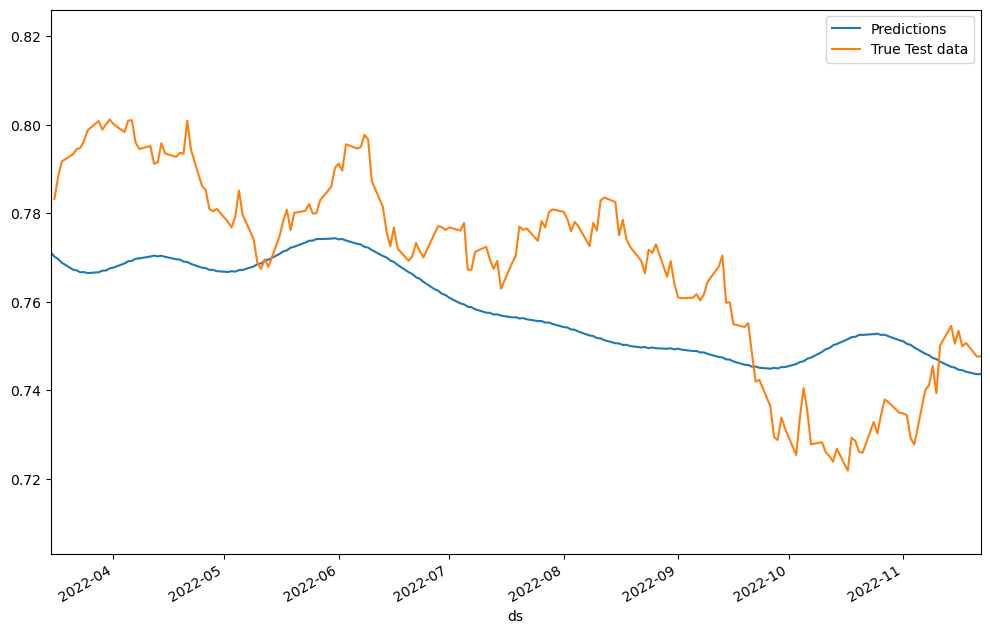

In [15]:
ax = forecast.plot(x='ds', y = 'yhat', label='Predictions', legend=True, figsize=(12,8))
test.plot(x='ds', y='y', label ='True Test data', legend=True, ax=ax, xlim = ('2022-03-15','2022-11-22'))

In [16]:
#calculate RMSE
predictions = forecast.iloc[-180:]['yhat']
predictions

1124    0.770164
1125    0.769607
1126    0.768783
1127    0.767233
1128    0.767053
          ...   
1299    0.744590
1300    0.744521
1301    0.744139
1302    0.743583
1303    0.743607
Name: yhat, Length: 180, dtype: float64

In [17]:
rmse(test['y'], predictions)

0.01863211618564846

In [18]:
##Fit the model on the full data
final_model = Prophet().fit(data)

22:58:36 - cmdstanpy - INFO - Chain [1] start processing
22:58:37 - cmdstanpy - INFO - Chain [1] done processing


In [19]:
##Test to forecast the future
prices = final_model.make_future_dataframe(periods = 180, freq='B')

In [20]:
forecast = final_model.predict(prices)

In [22]:
forecast.iloc[-180:]['yhat']

1304    0.732185
1305    0.732007
1306    0.731460
1307    0.730321
1308    0.730128
          ...   
1479    0.712271
1480    0.712353
1481    0.712039
1482    0.711448
1483    0.711394
Name: yhat, Length: 180, dtype: float64

In [25]:
forecast['ds']

0      2017-11-22
1      2017-11-23
2      2017-11-24
3      2017-11-27
4      2017-11-28
          ...    
1479   2023-07-26
1480   2023-07-27
1481   2023-07-28
1482   2023-07-31
1483   2023-08-01
Name: ds, Length: 1484, dtype: datetime64[ns]

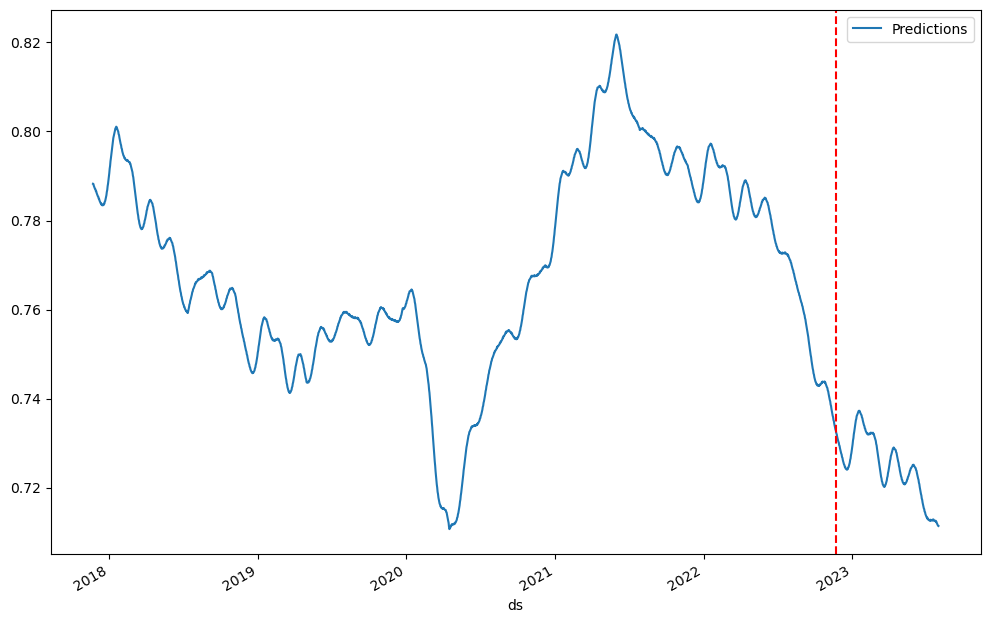

In [23]:
ax = forecast.plot(x='ds', y = 'yhat', label='Predictions', legend=True, figsize=(12,8))
ax.axvline(x= '2022-11-21', c='r', ls='--' )

In [36]:
#persist the model with joblib
joblib.dump(final_model, 'forecast_cadusd.joblib') 

['forecast_cadusd.joblib']

So how do I make this product code???

1. ApparentlyI have to create a directory for the model package